<a href="https://colab.research.google.com/github/poliduckie/MPC/blob/main/OpenCV/OpenCvLineExtractionPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Line extraction using openCV an PCA

Libraries import



In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Useful function to plot images in notebooks

In [ ]:
def imshow(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.show()

## Excract the line mask

Loading the image as a frame of the gif

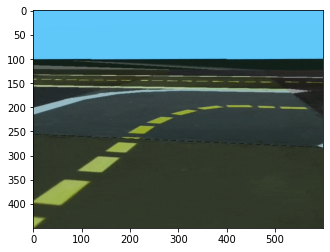

In [ ]:
SELECTED_FRAME = 60

cap = cv2.VideoCapture('./video1.gif')

cap.set(cv2.CAP_PROP_POS_FRAMES, SELECTED_FRAME)

ret, frame = cap.read()

cap.release()

imshow(frame)

Selecting the Red and Saturation channels

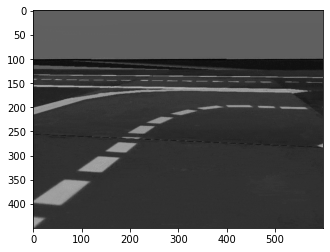

In [ ]:
def getR(frame):
    return frame[:,:,2]

R = getR(frame)
imshow(R)

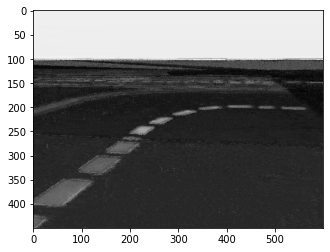

In [ ]:
def getS(frame):
    hls_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)
    return hls_frame[:, :, 2]

S = getS(frame)
imshow(S)

Thresholding the results

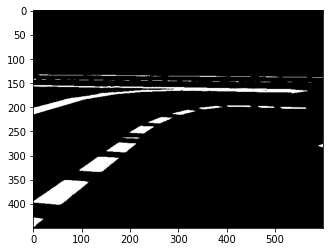

In [ ]:
def threshR(R, r_thresh):
    _, trR = cv2.threshold(R, r_thresh, 255, cv2.THRESH_BINARY)
    return trR

R_THRESH = 127
trR = threshR(R, R_THRESH)
imshow(trR)

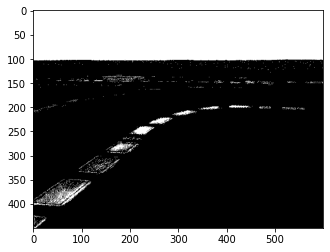

In [ ]:
def threshS(S, s_thresh):
    _, trS = cv2.threshold(S, s_thresh, 255, cv2.THRESH_BINARY)
    return trS

S_THRESH = 100
trS = threshS(S, S_THRESH)
imshow(trS)

Bitwise AND between the thresholded channels

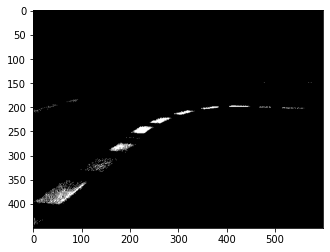

In [ ]:
def AndingChannels(trR, trS):
    return cv2.bitwise_and(trR, trS)

trRS = AndingChannels(trR, trS)
imshow(trRS)

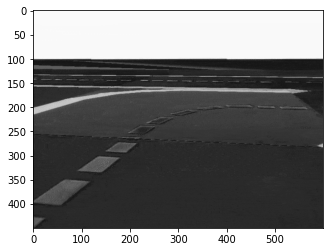

In [ ]:
def getB(frame):
    return frame[:, :, 0]

B = getB(frame)
imshow(B)

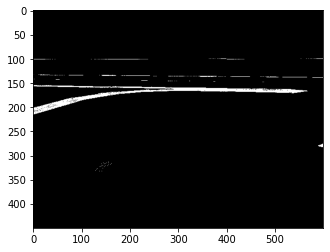

In [ ]:
B_MIN = 135
B_MAX = 200

def thresholdB(B):
    return cv2.inRange(B, B_MIN, B_MAX)

trB = thresholdB(B)

imshow(trB)

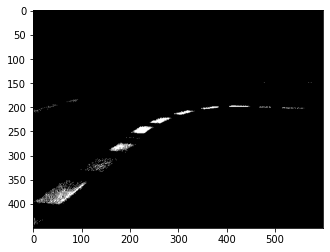

In [ ]:
def removeWhites(trRS, trB):
    return cv2.bitwise_and(trRS, cv2.bitwise_not(trB))

trRSnB =removeWhites(trRS, trB)

imshow(trRSnB)

## Bird eye view generation

Source and Destination points

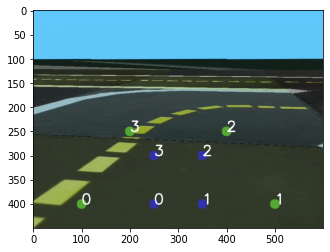

In [ ]:
SRC = np.float32([
    [100, 400],
    [500, 400],
    [400, 250],
    [200, 250],
])

DST = np.float32([
    [250, 400],
    [350, 400],
    [350, 300],
    [250, 300]
])

SRC_COLOR = (50, 168, 82)
DST_COLOR = (168, 50, 50)

CIRCLE_RADIUS = 10

FONT_SIZE = 1
TEXT_COLOR = (255, 255, 255)
FONT_THICK = 2

disp = frame.copy()

for i, s in enumerate(SRC):
    cv2.circle(disp, s.astype(int), CIRCLE_RADIUS, SRC_COLOR, -1)
    cv2.putText(disp, str(i), s.astype(int), cv2.FONT_HERSHEY_SIMPLEX, FONT_SIZE, TEXT_COLOR, FONT_THICK)

for i, d in enumerate(DST):
    cv2.circle(disp, d.astype(int), CIRCLE_RADIUS, DST_COLOR, -1)
    cv2.putText(disp, str(i), d.astype(int), cv2.FONT_HERSHEY_SIMPLEX, FONT_SIZE, TEXT_COLOR, FONT_THICK)

imshow(disp)

Computes the bird eye view transform

In [ ]:
def GetTransformMatrix(Src, Dst):
    return cv2.getPerspectiveTransform(Src, Dst)

M = GetTransformMatrix(SRC, DST)
print(M)

[[-7.50e-01 -3.00e+00  5.25e+02]
 [ 0.00e+00 -5.00e+00  8.00e+02]
 [-0.00e+00 -1.00e-02  1.00e+00]]


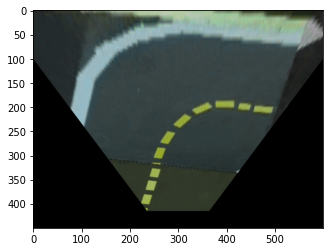

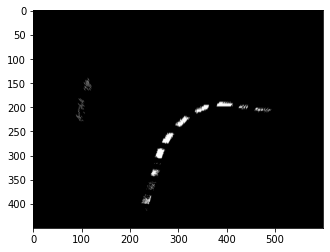

In [ ]:
def getBirdEye(image, M, dims):
    return cv2.warpPerspective(image, M, dims)

rows, cols, chan = frame.shape

BE_frame = getBirdEye(frame, M, (cols, rows))
imshow(BE_frame)

BE_trRS = getBirdEye(trRS, M, (cols, rows))
imshow(BE_trRS)

# Find a polyfit using the principal component rotation pass

In [ ]:
DEGREE = 4

Find the non zero elemnts of the mask and compute the transopesed

In [ ]:
Y_CUTTING = 150

def getNonVideo(image):
    nonZero = np.array(image[Y_CUTTING:].nonzero()[::-1], float)
    nonZero_t = nonZero.copy().transpose()

    return nonZero, nonZero_t


nonZero, nonZero_t = getNonVideo(BE_trRS)

Computes the mass center of the data

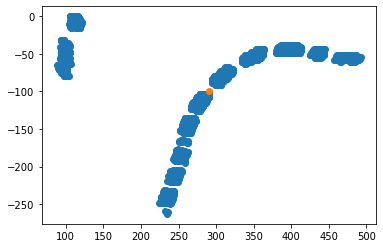

In [ ]:
def computeMassCenter(data):
    return np.sum(data, axis=1) / len(nonZero[0])

massCenter = computeMassCenter(nonZero)


plt.clf()
plt.scatter(nonZero[0], -nonZero[1])
plt.scatter(massCenter[0], -massCenter[1])
plt.show()

Shift the data in order to have the mass center in the origin

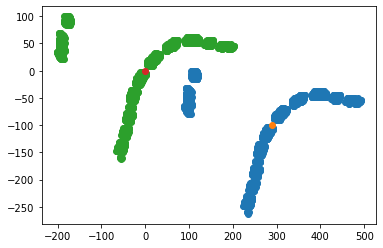

In [ ]:
def shiftData(nonZero_t, massCenter):
    return (nonZero_t - massCenter).T

shiftedData = shiftData(nonZero_t, massCenter)

plt.clf()
plt.scatter(nonZero[0], -nonZero[1])
plt.scatter(massCenter[0], -massCenter[1])

plt.scatter(shiftedData[0], -shiftedData[1])
plt.scatter(0, 0)

plt.show()

Normalize the data

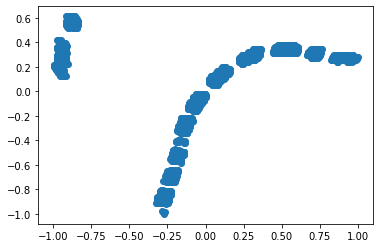

In [ ]:
def normalizeData(shiftedData):
    normalizedShiftedData = shiftedData.copy()

    normalizedShiftedData[0] /= max(np.max(normalizedShiftedData[0]), -np.min(normalizedShiftedData[0]))
    normalizedShiftedData[1] /= max(np.max(normalizedShiftedData[1]), -np.min(normalizedShiftedData[1]))

    return normalizedShiftedData

normalizedShiftedData = normalizeData(shiftedData)

plt.scatter(normalizedShiftedData[0], -normalizedShiftedData[1])

PCA

In [ ]:
from sklearn.decomposition import PCA

Variance Ratio: [0.64846938 0.35153062]
Principal components [[ 0.92033481 -0.39113147]
 [-0.39113147 -0.92033481]]


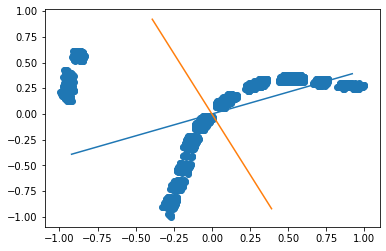

In [ ]:
def getPCA(normalizedShiftedData):
    pca = PCA(n_components=2)
    pca.fit(normalizedShiftedData.T)

    return pca

pca = getPCA(normalizedShiftedData)
print("Variance Ratio:", pca.explained_variance_ratio_)
print("Principal components", pca.components_)

points = np.array([pca.components_[0], -pca.components_[0]])
points = points.T

plt.scatter(normalizedShiftedData[0], -normalizedShiftedData[1])
plt.plot(points[0], -points[1])

points = np.array([pca.components_[1], -pca.components_[1]])
points = points.T
plt.plot(points[0], -points[1])

Compute the rotation matrices

In [ ]:
def computeTransformMatrices(pca):
    P_inv = pca.components_.T
    P = np.linalg.inv(P_inv)

    return P, P_inv

P, P_inv = computeTransformMatrices(pca)

Rotate the data

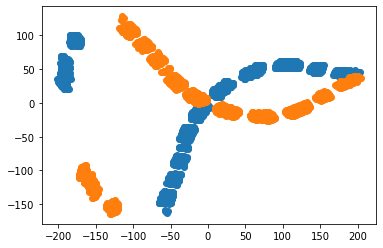

In [ ]:
def rotateData(shiftedData, P):
    return np.matmul(P, shiftedData)

rotatedData = rotateData(shiftedData, P)

plt.scatter(shiftedData[0], -shiftedData[1])
plt.scatter(rotatedData[0], -rotatedData[1])

## Standard polyfit

Find the polyfit

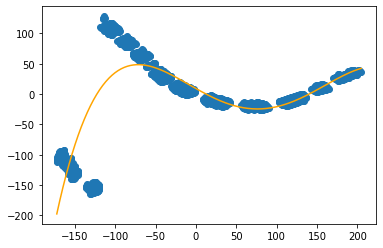

In [ ]:
def getCoeff(rotatedData):
    return np.polyfit(rotatedData[0], rotatedData[1], DEGREE)

polCoeff = getCoeff(rotatedData)

plt.scatter(rotatedData[0], -rotatedData[1])

def getDraws(rotatedData, polCoeff):
    draw_x = np.linspace(np.min(rotatedData[0]), np.max(rotatedData[0]), 200)
    draw_y = np.polyval(polCoeff, draw_x)

    return draw_x, draw_y

draw_x, draw_y = getDraws(rotatedData, polCoeff)

plt.plot(draw_x, -draw_y, color = 'orange')

Reverse all the shifting and rotation process to draw the line ontop of the original image

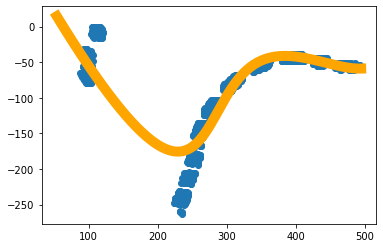

In [ ]:
def getDrawPoints(draw_x, draw_y, P_inv, massCenter):
    rotatedDraw = np.array([draw_x, draw_y])

    shiftedDraw = np.matmul(P_inv, rotatedDraw)

    drawPoints = (shiftedDraw.copy().transpose() + massCenter).transpose()

    return drawPoints

drawPoints = getDrawPoints(draw_x, draw_y, P_inv, massCenter)


plt.scatter(nonZero[0], -nonZero[1])
plt.plot(drawPoints[0], -drawPoints[1], color='orange', linewidth = 10)

## Polar Polyfit

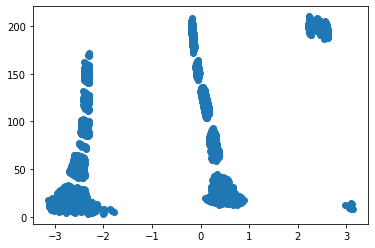

In [ ]:
x = rotatedData[0]
y = rotatedData[1]

r = np.sqrt(x**2+y**2)
t = np.arctan2(y, x)

plt.scatter(t, r)

Find the polyfit

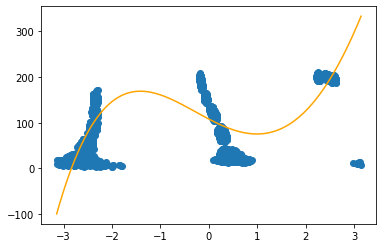

In [ ]:
polCoeff = np.polyfit(t, r, DEGREE)


plt.scatter(t, r)

draw_t = np.linspace(-np.pi, np.pi, 200)
draw_r = np.polyval(polCoeff, draw_t)
plt.plot(draw_t, draw_r, color = 'orange')

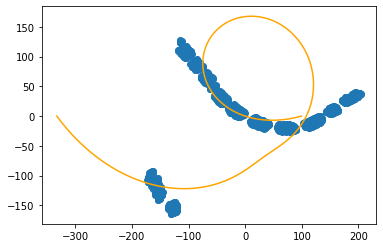

In [ ]:
draw_x_polar = draw_r * np.cos(draw_t)
draw_y_polar = draw_r * np.sin(draw_t)

plt.scatter(rotatedData[0], -rotatedData[1])
plt.plot(draw_x_polar, -draw_y_polar, color='orange')

## Result

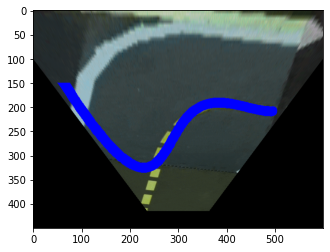

In [ ]:
def drawLines(disp, drawPoints):
    draw_points = (drawPoints.T).astype(np.int32)
    cv2.polylines(disp[Y_CUTTING:], [draw_points], False, (255, 0, 0), 20)


disp = BE_frame.copy()

drawLines(disp, drawPoints)

imshow(disp)

## Mega function

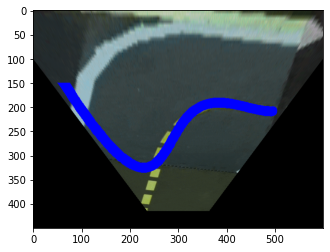

In [ ]:
def ExtractLine(frame):
    R = getR(frame)
    trR = threshR(R, R_THRESH)

    S = getS(frame)
    trS = threshS(S, S_THRESH)

    B = getB(frame)
    trB = thresholdB(B)

    trRS = AndingChannels(trR, trS)

    trRSnB =removeWhites(trRS, trB)

    if len(trRSnB) == 0:
        return None

    #return trRSnB

    M = GetTransformMatrix(SRC, DST)

    rows, cols, chan = frame.shape

    BE_frame = getBirdEye(frame, M, (cols, rows))
    BE_trRSnB = getBirdEye(trRSnB, M, (cols, rows))

    if len(BE_trRSnB) == 0:
        return None

    nonZero, nonZero_t = getNonVideo(BE_trRSnB)
    
    massCenter = computeMassCenter(nonZero)

    shiftedData = shiftData(nonZero_t, massCenter)

    if len(shiftedData[0]) < 20:
        return None

    normalizedShiftedData = normalizeData(shiftedData)

    pca = getPCA(normalizedShiftedData)
    
    P, P_inv = computeTransformMatrices(pca)

    rotatedData = rotateData(shiftedData, P)

    polCoeff = getCoeff(rotatedData)

    draw_x, draw_y = getDraws(rotatedData, polCoeff)

    drawPoints = getDrawPoints(draw_x, draw_y, P_inv, massCenter)

    disp = BE_frame.copy()

    drawLines(disp, drawPoints)

    return disp

imshow(ExtractLine(frame))
    

In [ ]:
from types import NoneType


cap = cv2.VideoCapture('./video1.gif')

frames = []

ret, frame = cap.read()

while type(frame) != NoneType:
    processedFrame = ExtractLine(frame)

    if type(processedFrame) != NoneType:
        frames.append(processedFrame)

    ret, frame = cap.read()

cap.release()

In [ ]:
import imageio

In [ ]:
with imageio.get_writer("resultPCA.gif", mode="I") as writer:
    for idx, frame in enumerate(frames):
        writer.append_data(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    print('Done')

Done
